In [1]:
from twittercrawler.utils import tweet_time_2_epoch
from datetime import datetime as dt
import numpy as np
import pandas as pd
import os

In [2]:
class TweetQuery():
    def __init__(self, tweet_dict):
        self._id = tweet_dict.get("id_str", None)
        self._user_name = tweet_dict["user"]["screen_name"] if "user" in tweet_dict else None
        self._user_id = tweet_dict["user"]["id_str"] if "user" in tweet_dict else None
        self._epoch = tweet_time_2_epoch(tweet_dict["created_at"]) if "created_at" in tweet_dict else None
        self._likes = tweet_dict.get("favorite_count", None)
        self._retweets = tweet_dict.get("retweet_count", None)
        self._max_id = None
        self._since_id = int(self._id) if self._id != None else None
        self._last_access = None
        
    def set_epoch(self, epoch):
        self._epoch = epoch
        
    def set_max_id(self, max_id):
        self._max_id = max_id
        
    def set_since_id(self, since_id):
        self._since_id = int(since_id)
        
    def mark_access(self):
        self._last_access = dt.now()
        
    def copy(self):
        params = {
            "id_str":self.id,
            "favorite_count":self.likes,
            "retweet_count":self.retweets,
            "user":{
                "id_str": self.user_id,
                "screen_name": self.user_name
            }
        }
        copy_q = TweetQuery(params)
        copy_q.set_epoch(self.epoch)
        copy_q.set_max_id(self.max_id)
        copy_q.set_since_id(self.since_id)
        return copy_q
        
    def __repr__(self):
        return "(%s, %s, %s, %s, %i, %i, %s, %s)" % (self.id, self.user_id, self.user_name, self.dt, self.likes, self.retweets, self.max_id, self.since_id)
    
    @property
    def id(self):
        return self._id
    
    @property
    def user_name(self):
        return self._user_name
    
    @property
    def user_id(self):
        return self._user_id
    
    @property
    def epoch(self):
        return self._epoch
    
    @property
    def dt(self):
        return dt.fromtimestamp(self.epoch)
    
    @property
    def likes(self):
        return self._likes
    
    @property
    def retweets(self):
        return self._retweets
    
    @property
    def max_id(self):
        return self._max_id
    
    @property
    def since_id(self):
        return self._since_id
    
    @property
    def elapsed_days(self):
        return (dt.now() - self.dt).days
    
    @property
    def accessed_since_days(self):
        if self._last_access == None:
            return -1
        else:
            return (dt.now() - self._last_access).days
        
    @property
    def priority(self):
        if self.max_id != None:
            return 10.0
        elif self.accessed_since_days == 0:
            return 0.0
        else:
            return self.elapsed_days + np.log10(1.0+self.likes+self.retweets)

In [3]:
class UserTweetStore():
    def __init__(self):#dir_path):
        #self._dir_path = dir_path
        self.user_intervals = {}
        
    #@property
    #def dir_path(self):
    #    if not os.path.exists(self._dir_path):
    #        os.makedirs(self._dir_path)
    #    return self._dir_path
    
    def get_user(self, user_id):
        return self.user_intervals.get(user_id, [None, None])
    
    def update(self, query, latest_id):
        user_id = query.user_id
        from_id, to_id = self.get_user(user_id)
        qid = int(query.id)
        if from_id == None or qid < from_id:
            from_id = qid
        if to_id == None or latest_id > to_id:
            to_id = latest_id
        self.user_intervals[user_id] = [from_id, to_id]
    
    def adjust_query(self, query):
        from_id, to_id = self.get_user(query.user_id)
        queries = []
        if from_id == None:
            queries.append(query)
        else:
            if query.since_id < from_id:
                q = query.copy()
                q.set_max_id(from_id)
            # avoid collecting the same data twice
            query.set_since_id(to_id)
            queries.append(query)
        return queries

from twittercrawler.crawlers import RecursiveCrawler
from twittercrawler.utils import load_json_result
    
class SearchEngine():
    def __init__(self, reset=False, api_key_fp="../api_key.json", output_fp="sample.txt", tweet_mode="extended"):
        self.reset = reset
        self.tweet_mode = tweet_mode
        self.output_fp = output_fp
        self.api_key_fp = api_key_fp
        self.store = UserTweetStore()
        self._init_crawler()
        
    def _init_crawler(self):
        if self.reset and os.path.exists(self.output_fp):
            os.remove(self.output_fp)
            print("Engine output file was cleared!")
        self.crawler = RecursiveCrawler()
        self.crawler.authenticate(self.api_key_fp)
        
    def get_status(self, tweet_id):
        return self.crawler.twitter_api.show_status(id=tweet_id, tweet_mode=self.tweet_mode)
        
    def collect_replies(self, query, count=100, result_type='recent'):
        search_params = {
            "q" : "to:%s" % query.user_name,
            "result_type" : result_type,
            "count" : count,
            "tweet_mode" : self.tweet_mode
        }
        #print(search_params, query.since_id)
        self.crawler.connect_to_file(self.output_fp)# TODO: later rewise whteher to use multiple files for users
        self.crawler.set_search_arguments(search_args=search_params)
        if query.max_id != None:
            result = self.crawler.search(wait_for=3, feedback_time=15, current_max_id=query.max_id, custom_since_id=query.since_id)
        else:
            result = self.crawler.search(wait_for=3, feedback_time=15, custom_since_id=query.since_id)
        self.crawler.close()
        return result
    
    def extract_replies(self, query):
        reply_tweets = load_json_result(self.output_fp)
        #print("Hits:", len(reply_tweets))
        replies = []
        for tweet in reply_tweets:
            replied_tweet = tweet.get("in_reply_to_status_id_str", None)
            if replied_tweet == query.id and tweet["id"]:# > query.since_id:
                replies.append(tweet)
        return replies
        
    # TODO: nagyon átgondolni!!!
    def execute(self, original_query):
        queries = self.store.adjust_query(original_query)
        for idx, query in enumerate(queries):
            success, max_id, latest_id, cnt = self.collect_replies(query)
            print(idx, success, max_id, latest_id, cnt)
            if success:
                if cnt > 0:
                    self.store.update(query, latest_id)
            else:
                break
        replies = []
        if success:
            replies = self.extract_replies(original_query)
            original_query.mark_access()
            if cnt > 0:
                original_query.set_since_id(latest_id)
                original_query.set_max_id(None)
        else:
            original_query.set_max_id(max_id)
        return success, original_query, replies
        
from collections import deque

class ReplyCollector():
    def __init__(self, tweet_id, likes_limit=0, postpone_day_limit=3, action_day_limit=5, reset=False):
        self.tweet_id = tweet_id
        self.likes_limit = likes_limit
        self.postpone_day_limit = postpone_day_limit
        self.action_day_limit = action_day_limit
        self.engine = SearchEngine(output_fp="%s.txt" % self.tweet_id, reset=reset)
        self.seed_tweet = self.engine.get_status(self.tweet_id)
        self.tweet_thread = [self.seed_tweet]
        print(self.seed_tweet['full_text'])
        self._queue = deque([TweetQuery(self.seed_tweet)])
        self.active_tweet_ids = []
        
    @property
    def queue(self):
        return self._queue
    
    def _sort_queries(self):
        self._queue = deque(sorted(self._queue, key=lambda x: x.priority, reverse=True))
        
    #def sort_queries(self, queries):
    #    return sorted(queries, key=lambda x: x.since_id)
        
    def _decide_execution(self, query):
        if query.elapsed_days < self.postpone_day_limit:
            execute_now = False
        elif query.elapsed_days >= self.action_day_limit:
            # here we try to catch the begining of each thread
            execute_now = True
        else:
            if query.likes >= self.likes_limit:
                execute_now = True
            else:
                execute_now = False
        return execute_now
        
    def run(self):
        Q = 1
        while len(self.queue) > 0:
            query = self.queue.popleft()
            print(query)
            if query.priority == 0:
                self._queue.appendleft(query)
                break
            execute_now = self._decide_execution(query)
            if execute_now:
                success, new_query, replies = self.engine.execute(query)
                print(query.id,len(replies))
                self.tweet_thread += replies
                df = pd.DataFrame(self.tweet_thread)
                df.to_pickle("%s.pkl" % self.tweet_id)
                for reply in replies:
                    q = TweetQuery(reply)
                    if not q.id in self.active_tweet_ids:
                        self._queue.append(q)
                        Q += 1
                Q -= 1
                self._queue.append(new_query)
                self._sort_queries()
                if not success:
                    break
                #print([q.priority for q in self.queue])
            else:
                self._queue.append(query)
            print("Remaining queries:", Q)
        # TODO: records are never deleted from the queue!!!

#https://twitter.com/hadleywickham/status/1347260334227259394
collector = ReplyCollector("1347260116932976643", likes_limit=0, postpone_day_limit=0, action_day_limit=1, reset=True)

#https://twitter.com/nicvadivelu/status/1347267259266318336/photo/1
collector = ReplyCollector("1347267259266318336", likes_limit=0, postpone_day_limit=0, action_day_limit=0, reset=True)

#https://twitter.com/Dr2NisreenAlwan/status/1347833203080523776
collector = ReplyCollector("1347833203080523776", likes_limit=5, postpone_day_limit=0, action_day_limit=5, reset=True)

#https://twitter.com/indepdubnrth/status/1347979792839274499
collector = ReplyCollector("1347979792839274499", likes_limit=5, postpone_day_limit=0, action_day_limit=5, reset=True)

In [4]:
#https://twitter.com/RandPaul/status/1347930653904556036
collector = ReplyCollector("1347930653904556036", likes_limit=5, postpone_day_limit=0, action_day_limit=5, reset=True)

Authentication was successful!
By all means, follow the science:  if you’ve been infected with COVID and survived you have long lasting immunity! This should allow us to direct the vaccine to people who haven’t yet been infected. Follow the science! https://t.co/Bw4KI3zUgI


In [5]:
collector.run()

(1347930653904556036, 216881337, RandPaul, 2021-01-09 15:38:05, 6011, 1838, None, 1347930653904556036)
{'q': 'to:RandPaul', 'result_type': 'recent', 'count': 100, 'tweet_mode': 'extended'}
### FEEDBACK ###
Recursive search is RUNNING since: 0 days, 0 hours and 0 minutes 17 seconds
max_id: 1347940810046775296, since_id: 1347930653904556036, latest_id: 1348032917885263872
### FEEDBACK ###
Recursive search is RUNNING since: 0 days, 0 hours and 0 minutes 32 seconds
max_id: 1347931005089419264, since_id: 1347930653904556036, latest_id: 1348032917885263872
Connection was closed successfully!
0 True 1347930720774152192 1348032917885263872 557
1347930653904556036 354
Remaining queries: 354
(1347931466135527427, 53041977, vertreko, 2021-01-09 15:41:19, 204, 29, None, 1347931466135527427)
{'q': 'to:vertreko', 'result_type': 'recent', 'count': 100, 'tweet_mode': 'extended'}
Connection was closed successfully!
0 True 1347931842326966273 1347989950843793408 10
1347931466135527427 4
Remaining querie

### TODO: show number of remaining queries in the queue
### TODO: stop after executing a few queries...

In [6]:
#tweet_id = "1347260116932976643"
#tweet_id = "1347833203080523776"
#tweet_id = "1347979792839274499"
tweet_id = "1347930653904556036"
thread_df = pd.read_pickle("%s.pkl" % tweet_id)
repliers = set()
edges = []
mentions = []
#thread_events = sorted(collector.tweet_thread, key=lambda x: x["id"])
#for tw in thread_events:
for _, tw in thread_df.iterrows():
    if tw["in_reply_to_status_id_str"] != None:
        edges.append((tw["id_str"],tw["in_reply_to_status_id_str"]))
        mentions.append((tw["user"]["id_str"],tw["in_reply_to_user_id_str"]))
    #repliers.add(tw["user"]["screen_name"])
    #print(tw["user"]["screen_name"], tw["created_at"])
    #print(tw["full_text"])
    #print()
print(len(edges), len(collector.queue))

416 417


In [7]:
import networkx as nx
G = nx.DiGraph()
H = nx.MultiDiGraph()
G.add_edges_from(edges)
_ = H.add_edges_from(mentions)

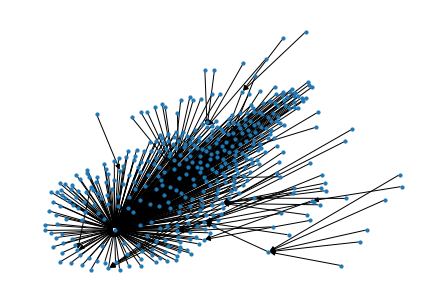

In [11]:
nx.draw(G, node_size=10)

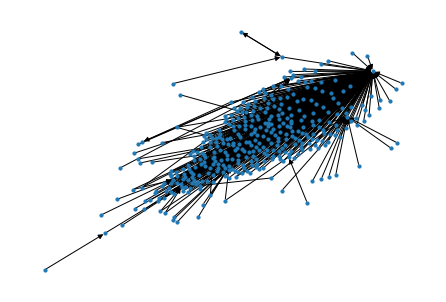

In [10]:
nx.draw(H, node_size=10)